In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec 
from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.simplefilter(action='ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm

In [21]:
train = pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\house_price_prediction\data/train.csv')
test = pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\house_price_prediction\data/test.csv')

In [22]:
test_id = test['Id']

In [23]:
df = train

In [24]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [25]:
df.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

In [26]:
train = df


In [27]:
print(f"Number of rows and number of columns in the train dataset are {train.shape[0]} and {train.shape[1]}")
print(f"Number of rows and number of columns in the test dataset are {test.shape[0]} and {test.shape[1]}")

Number of rows and number of columns in the train dataset are 1460 and 80
Number of rows and number of columns in the test dataset are 1459 and 79


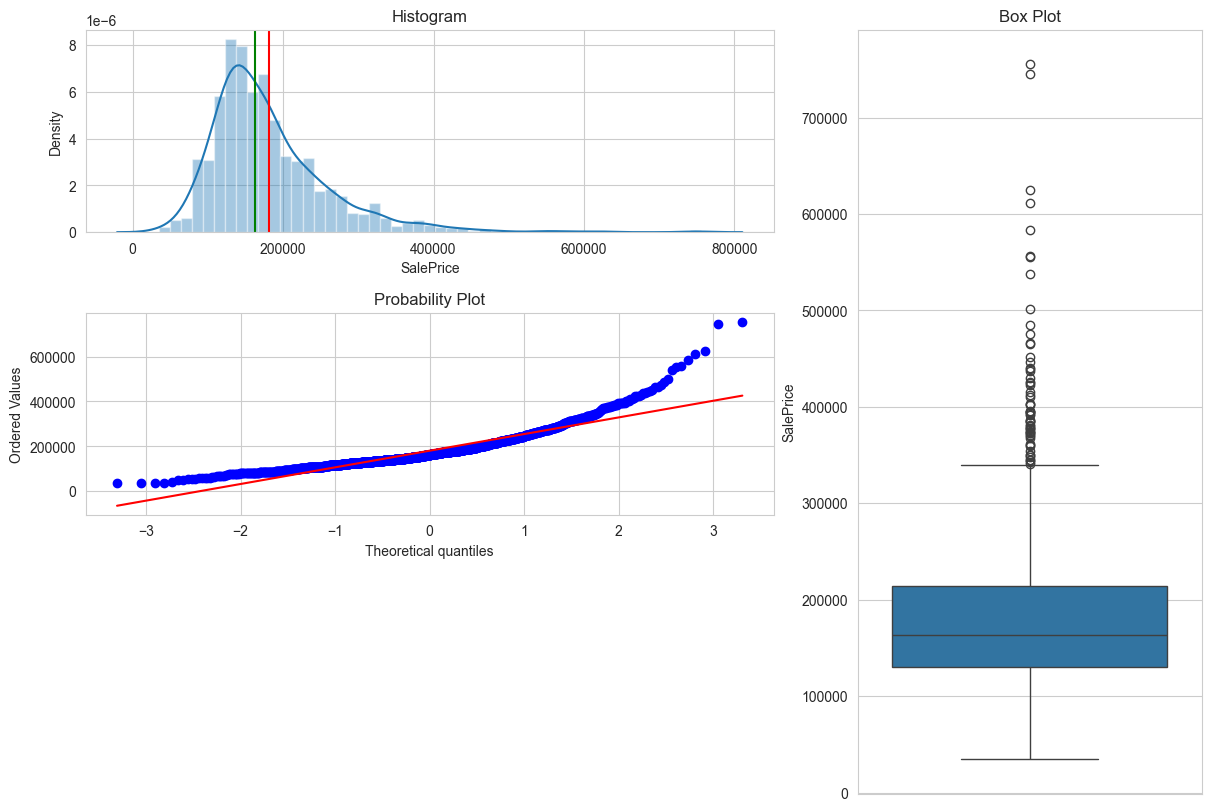

In [28]:
def three_chart_plot(df, feature):
    fig = plt.figure(constrained_layout = True, figsize = (12, 8))
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)
    
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    
    sns.distplot(df.loc[:, feature], norm_hist = True, ax = ax1)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')
    
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:,feature], orient = 'v', ax = ax3 )
    
three_chart_plot(df, 'SalePrice')

In [29]:
from scipy.stats import skew
print("Skewness of the SalesPrice is", df['SalePrice'].skew())

Skewness of the SalesPrice is 1.8828757597682129


<Axes: >

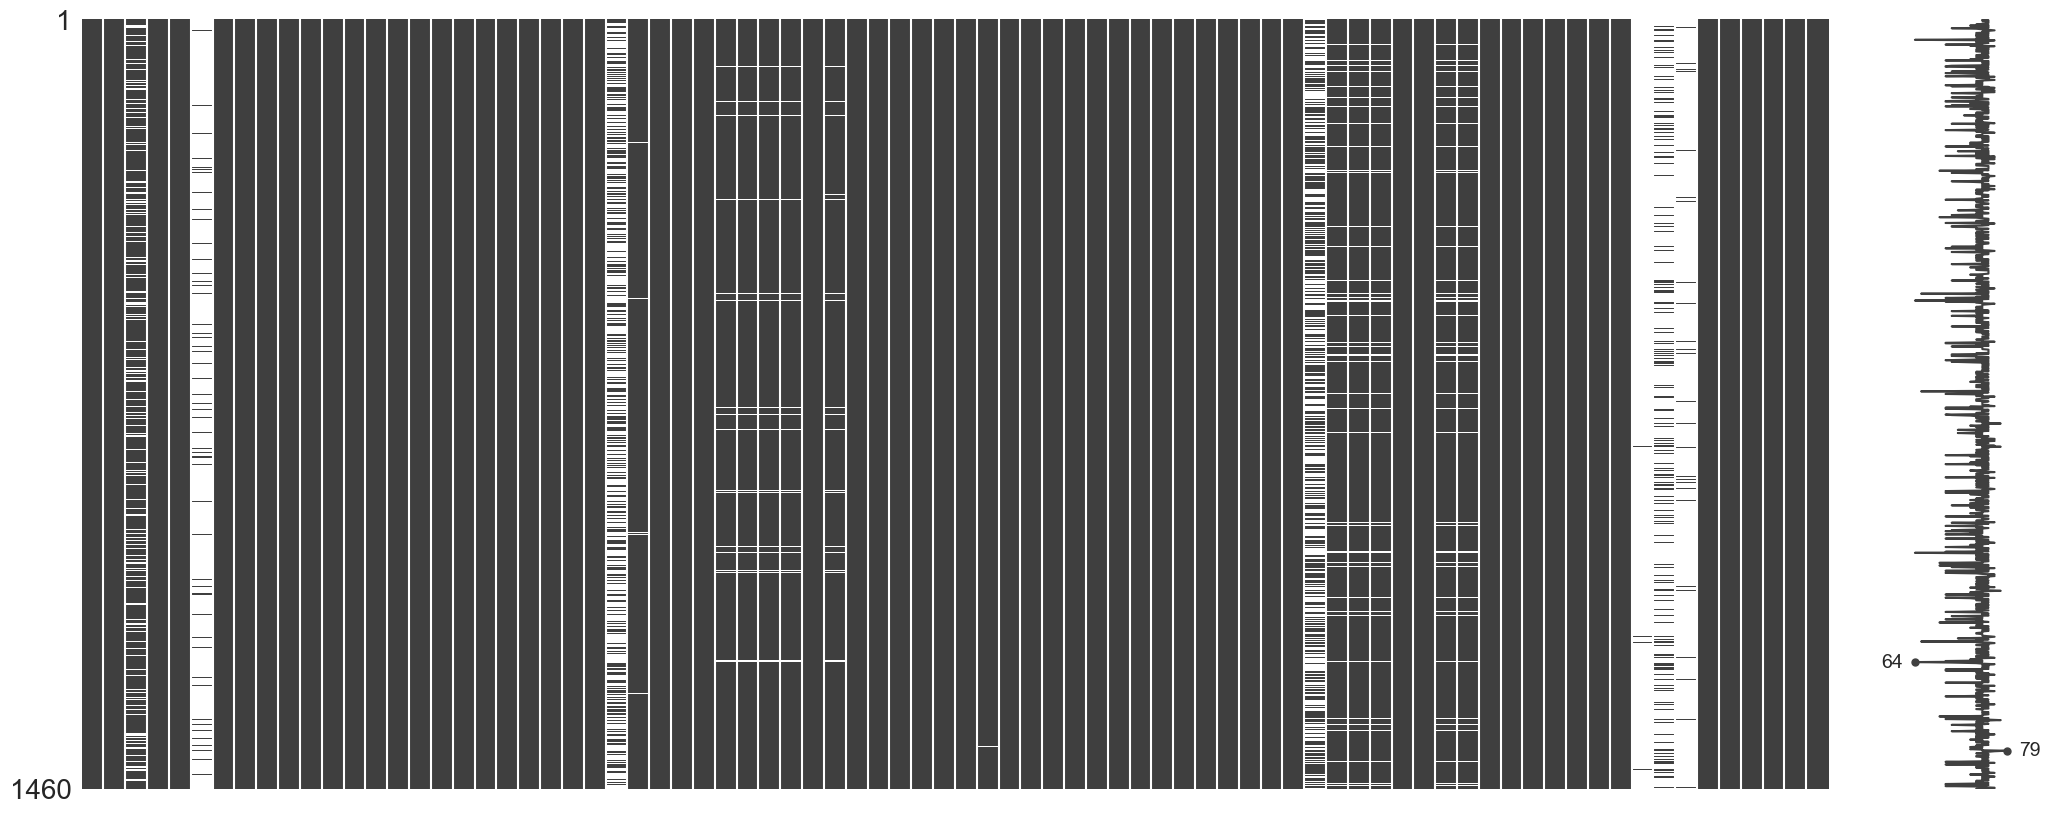

In [31]:
import missingno as msno
%matplotlib inline
msno.matrix(train)

<Axes: >

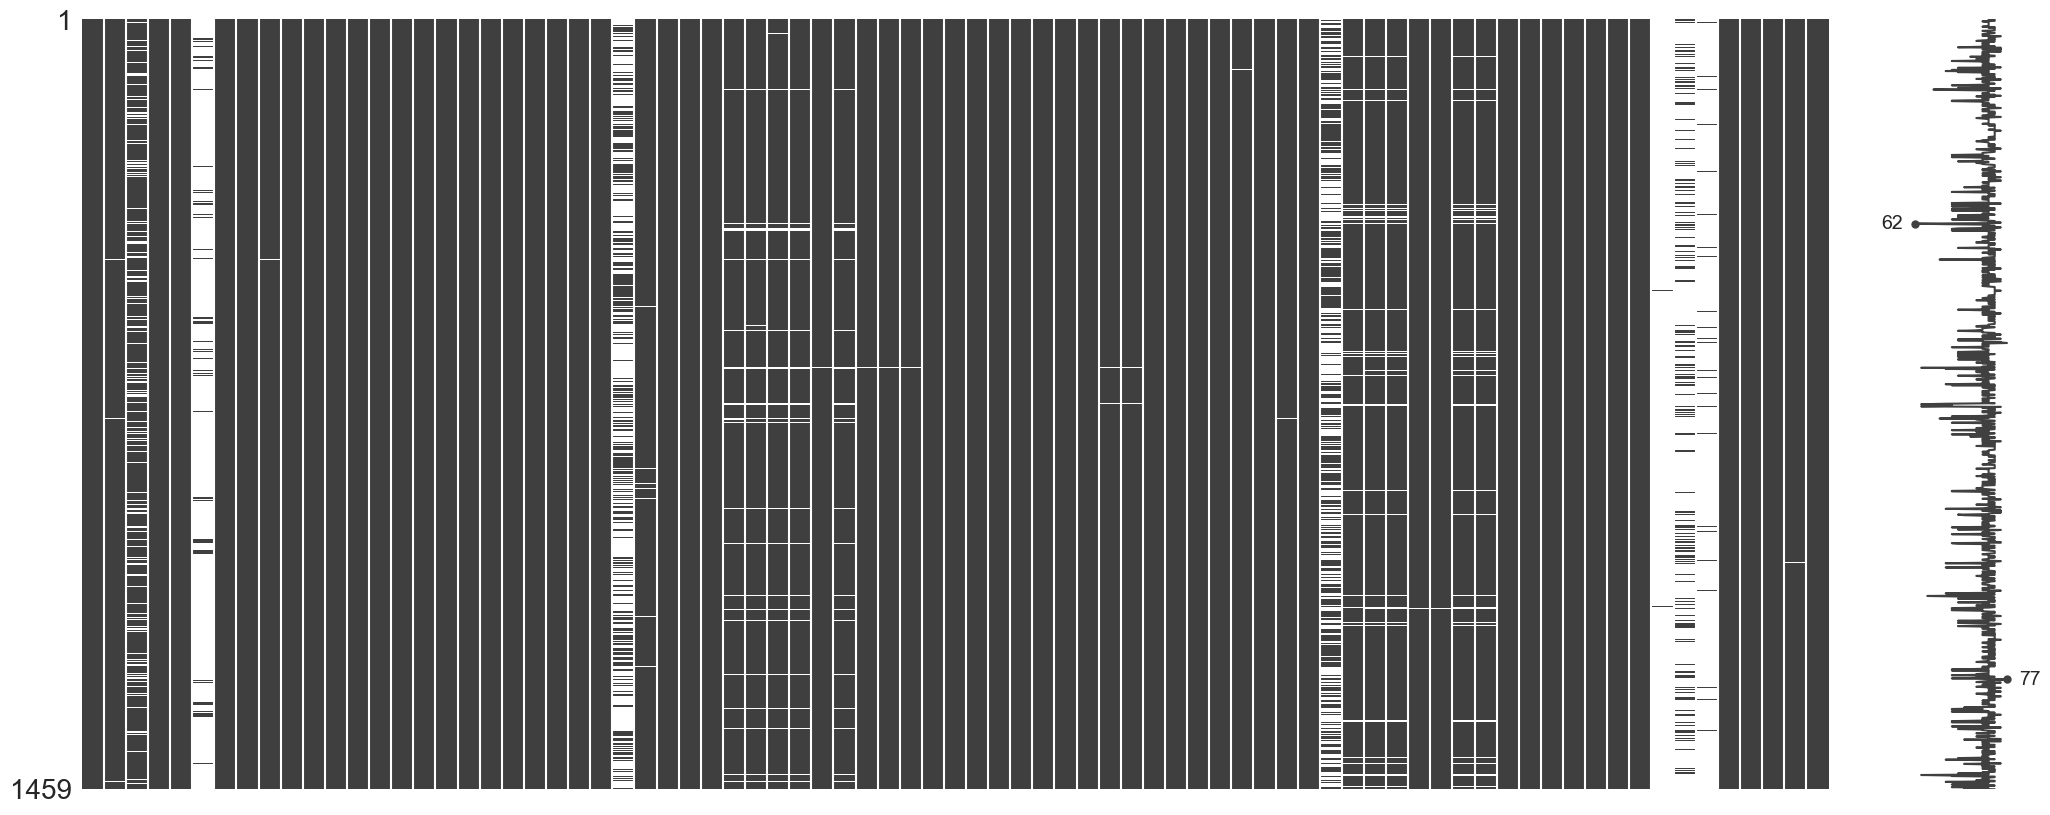

In [32]:
msno.matrix(test)


In [33]:
def null_table(data):
    indices = data.isnull().sum().index
    values = data.isnull().sum().values
    percentages = []
    for i in indices:
        percentages.append((data[i].isnull().sum() / data[i].shape[0]) * 100)
    d = {'Columns' : indices, 'Count of Null Values' : values, 'Approximate Percentage of Null Values' : percentages}
    # data = dict(zip(indices, percentages))
    null_frame = pd.DataFrame(data = d)
    return null_frame

In [34]:
null_frame_train = null_table(df)
null_frame_train.sort_values(by = 'Approximate Percentage of Null Values').tail(10)

,Columns,Count of Null Values,Approximate Percentage of Null Values
59,GarageFinish,81,5.547945
62,GarageQual,81,5.547945
58,GarageYrBlt,81,5.547945
2,LotFrontage,259,17.739726
56,FireplaceQu,690,47.260274
24,MasVnrType,872,59.726027
72,Fence,1179,80.753425
5,Alley,1369,93.767123
73,MiscFeature,1406,96.301370
71,PoolQC,1453,99.520548


In [35]:
null_frame_test = null_table(test)
null_frame_test.sort_values(by = 'Approximate Percentage of Null Values').tail(10)

,Columns,Count of Null Values,Approximate Percentage of Null Values
63,GarageCond,78,5.346127
59,GarageFinish,78,5.346127
62,GarageQual,78,5.346127
2,LotFrontage,227,15.558602
56,FireplaceQu,730,50.034270
24,MasVnrType,894,61.274846
72,Fence,1169,80.123372
5,Alley,1352,92.666210
73,MiscFeature,1408,96.504455
71,PoolQC,1456,99.794380


In [36]:
na = train.shape[0]
nb = test.shape[0]
y_train = train['SalePrice'].to_frame()
# Combine train and test sets
total = pd.concat((train, test), sort = False).reset_index(drop = True)
# Drop the target "SalePrice" and Id columns
total.drop(['SalePrice'], axis = 1, inplace = True)
print(f"Total size is {total.shape}")

Total size is (2919, 79)


In [37]:
def msv_1(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):
    
    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')
    
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()

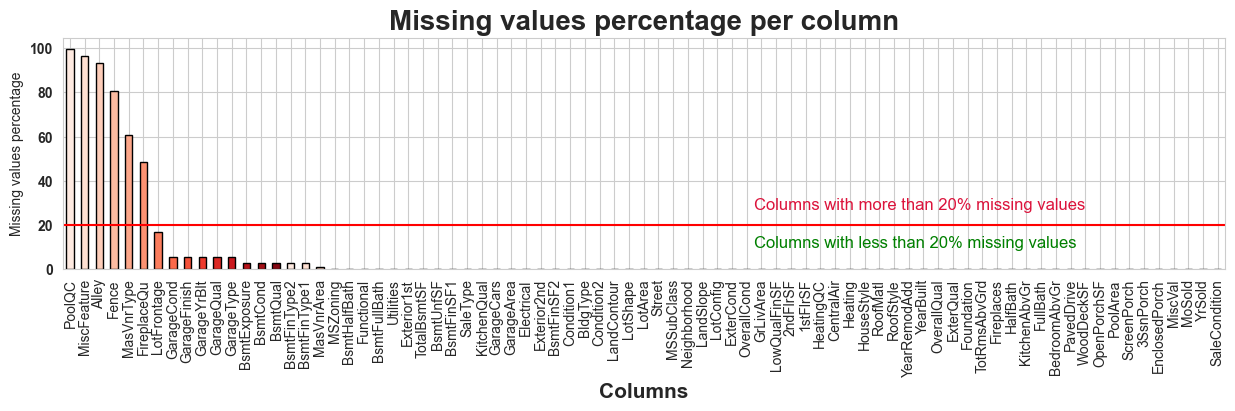

In [38]:
msv_1(total, 20, color=sns.color_palette('Reds',15))


## Numerical and Categorical Variables

### Exploring Numerical Variables

In [40]:
category_var = df.select_dtypes(include = 'object')
num_var = df.select_dtypes(exclude = 'object')

print("Number of categorical features are: ", category_var.shape[1])
print("Number of numerical features are: ", num_var.shape[1])

Number of categorical features are:  43
Number of numerical features are:  37


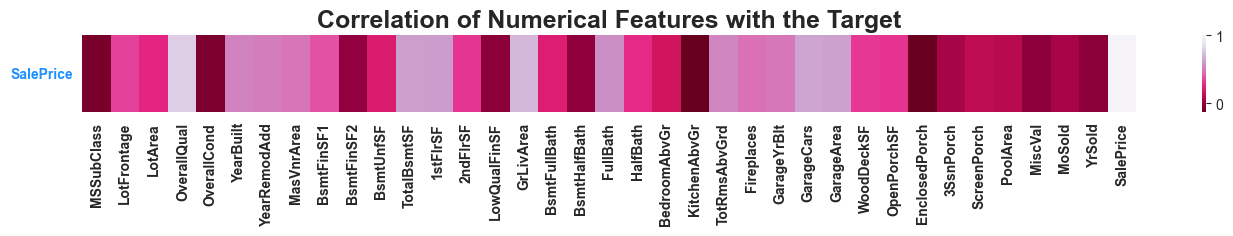

In [41]:
num = df.select_dtypes(exclude = 'object')
corr_num = num.corr()

f, ax = plt.subplots(figsize = (17, 1))

sns.heatmap(corr_num.sort_values(by = ['SalePrice'], ascending = False).head(1), cmap='PuRd_r')

plt.title('Correlation of Numerical Features with the Target', weight = 'bold', fontsize = 18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

plt.show()

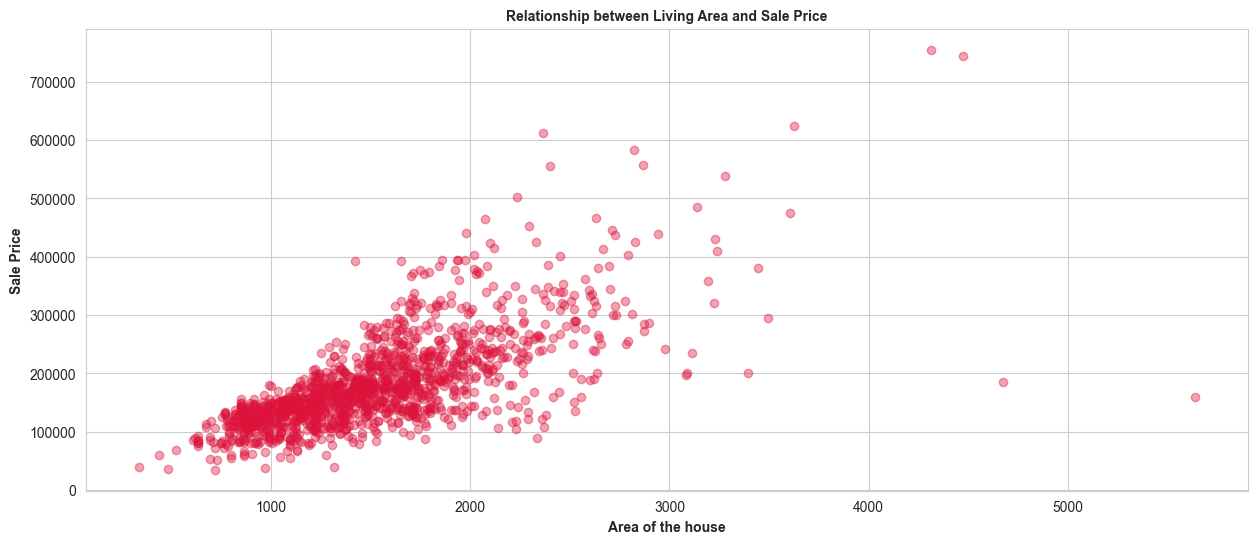

In [45]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GrLivArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Living Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the house', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

In [46]:
train = train[train['GrLivArea'] < 4500]
previous_train = df
df = train

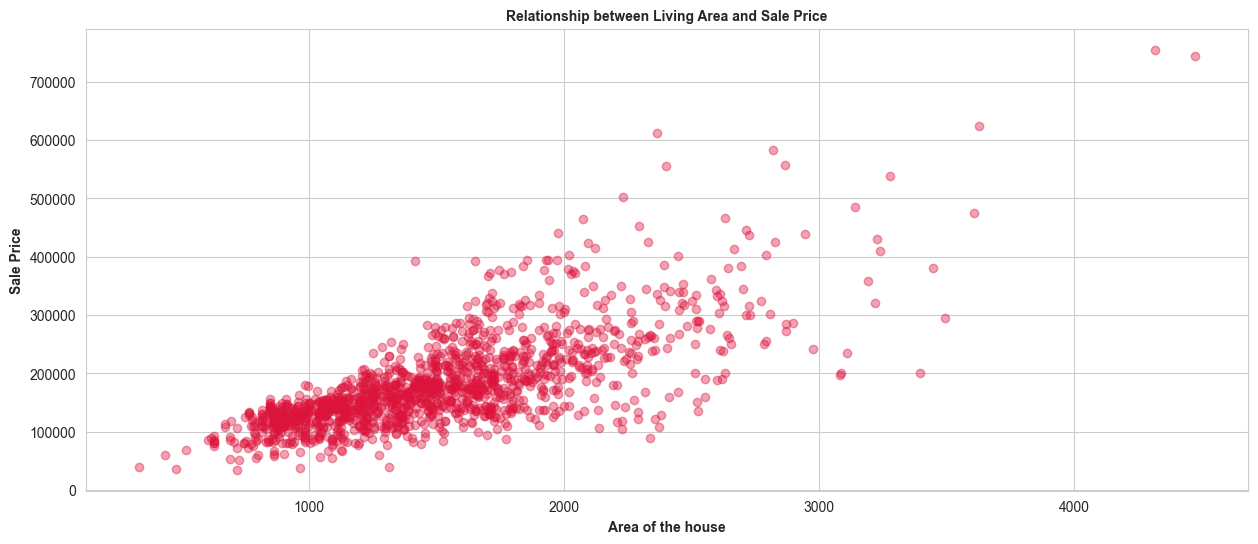

In [47]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GrLivArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Living Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the house', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()


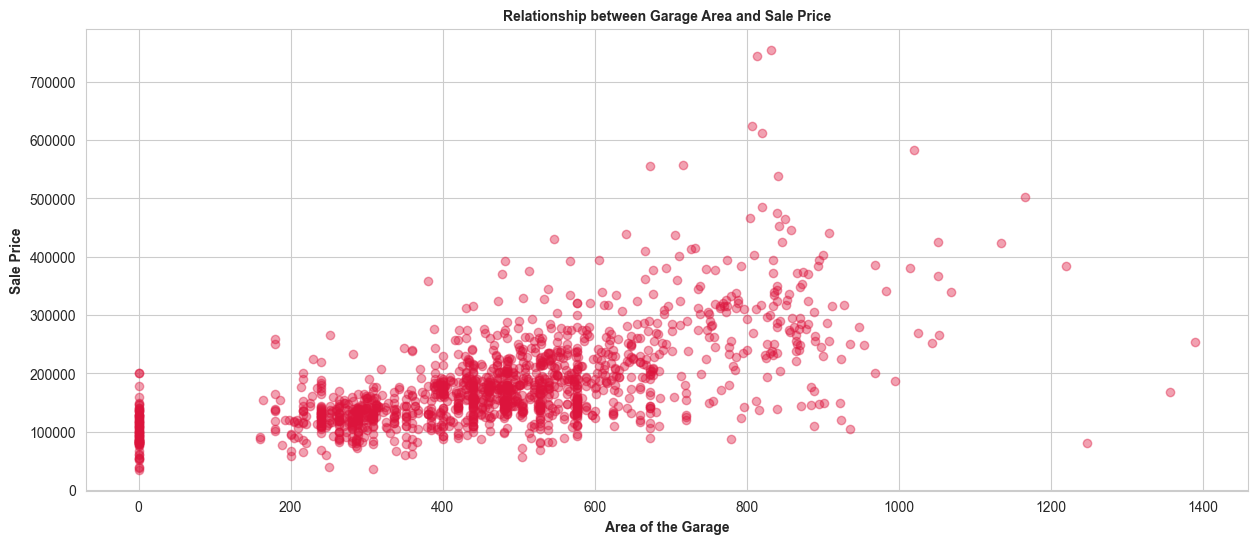

In [48]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GarageArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Garage Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the Garage', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

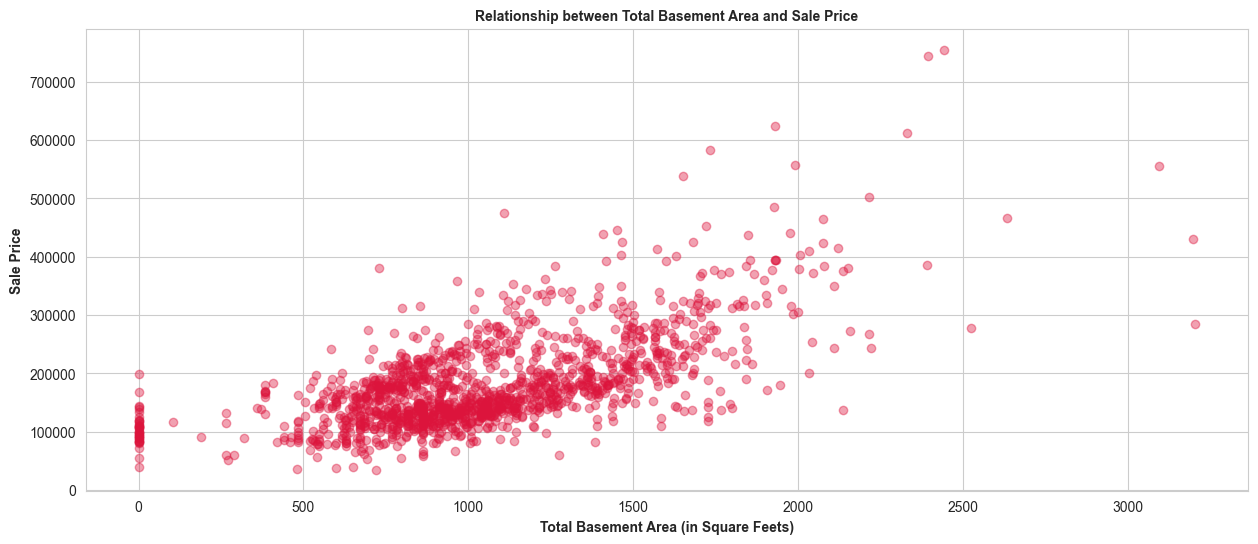

In [49]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'TotalBsmtSF', y = 'SalePrice', data = df, color = 'crimson', alpha = 0.4)
plt.title('Relationship between Total Basement Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Total Basement Area (in Square Feets)', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()


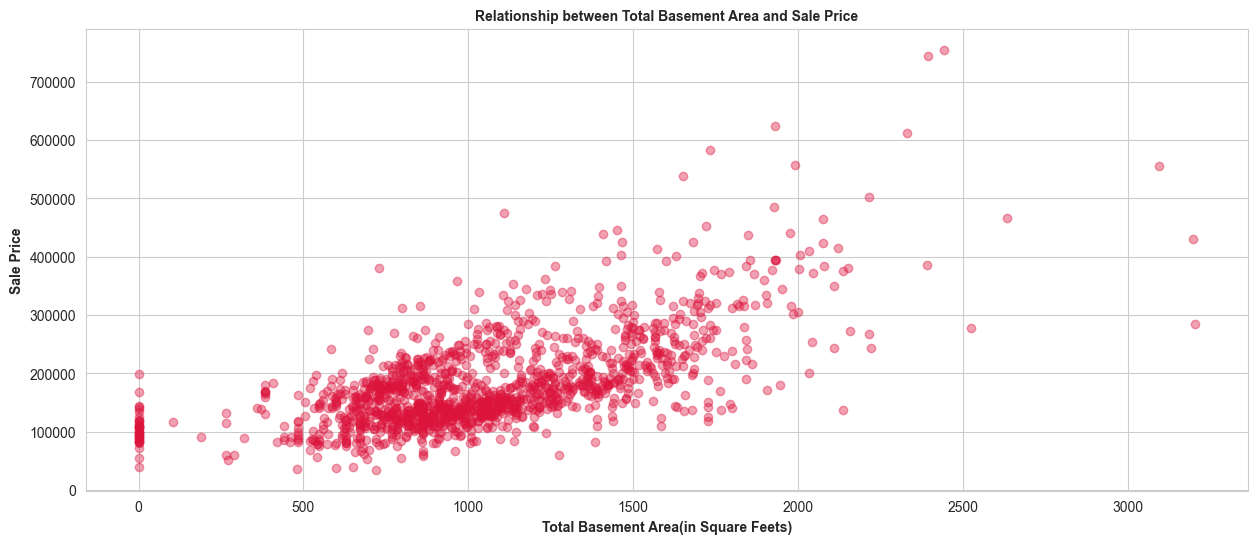

In [50]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'TotalBsmtSF', y = 'SalePrice', data = df, color = 'crimson', alpha = 0.4)
plt.title('Relationship between Total Basement Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Total Basement Area(in Square Feets)', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

<Axes: xlabel='MasVnrArea', ylabel='SalePrice'>

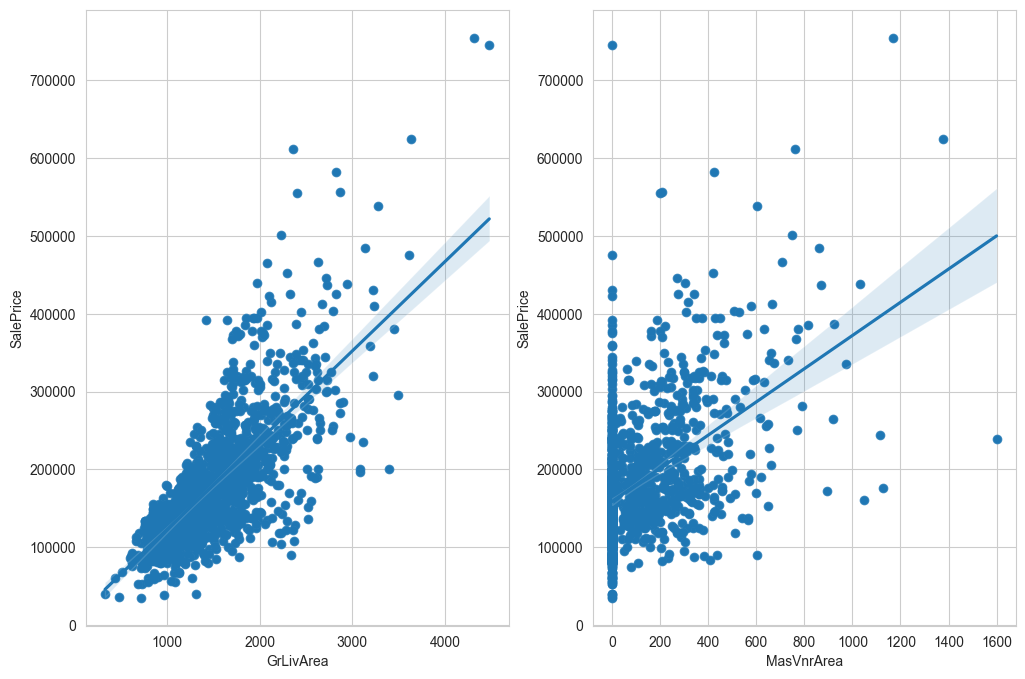

In [51]:
fig, (ax1, ax2) = plt.subplots(figsize = (12, 8), ncols = 2,sharey = False)
 
sns.scatterplot(x = df['GrLivArea'], y = df['SalePrice'],  ax = ax1) 
sns.regplot(x = df['GrLivArea'], y = df['SalePrice'], ax = ax1)

sns.scatterplot(x = df['MasVnrArea'],y = df['SalePrice'], ax = ax2)
sns.regplot(x = df['MasVnrArea'], y = df['SalePrice'], ax=ax2)

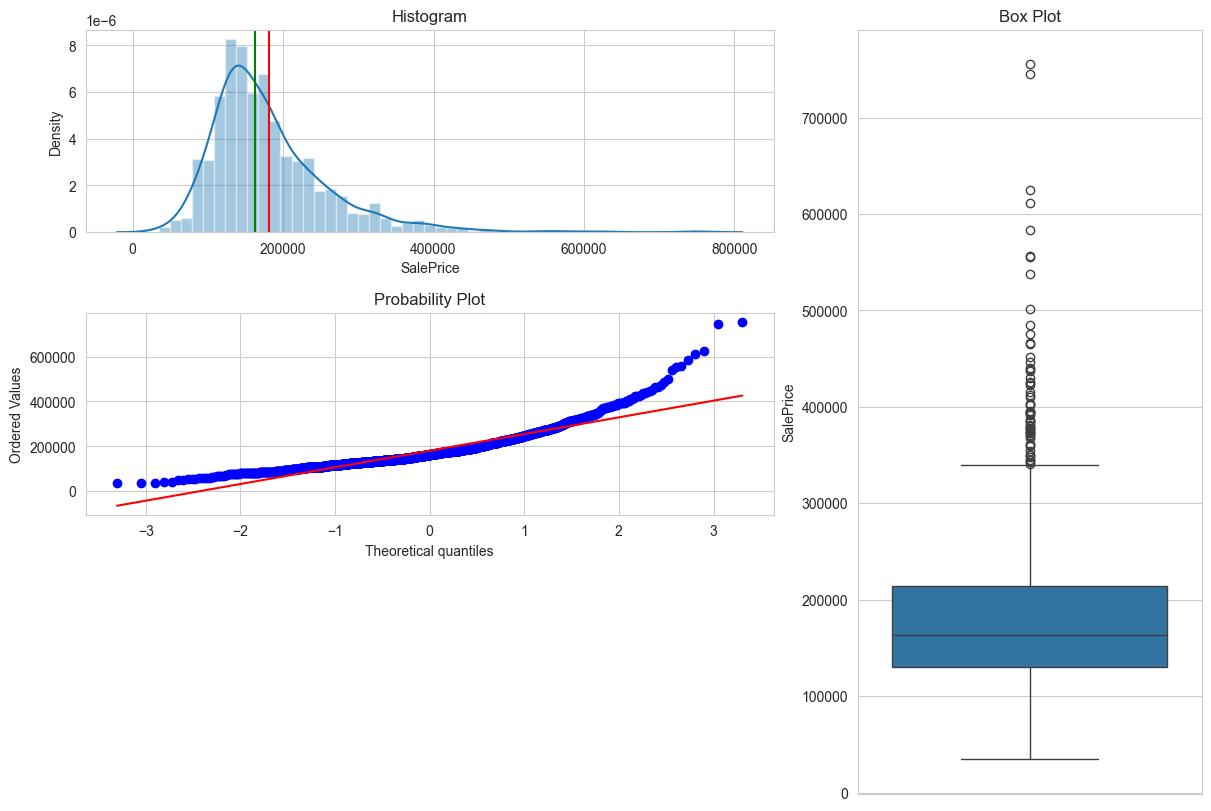

In [57]:
three_chart_plot(df, 'SalePrice')

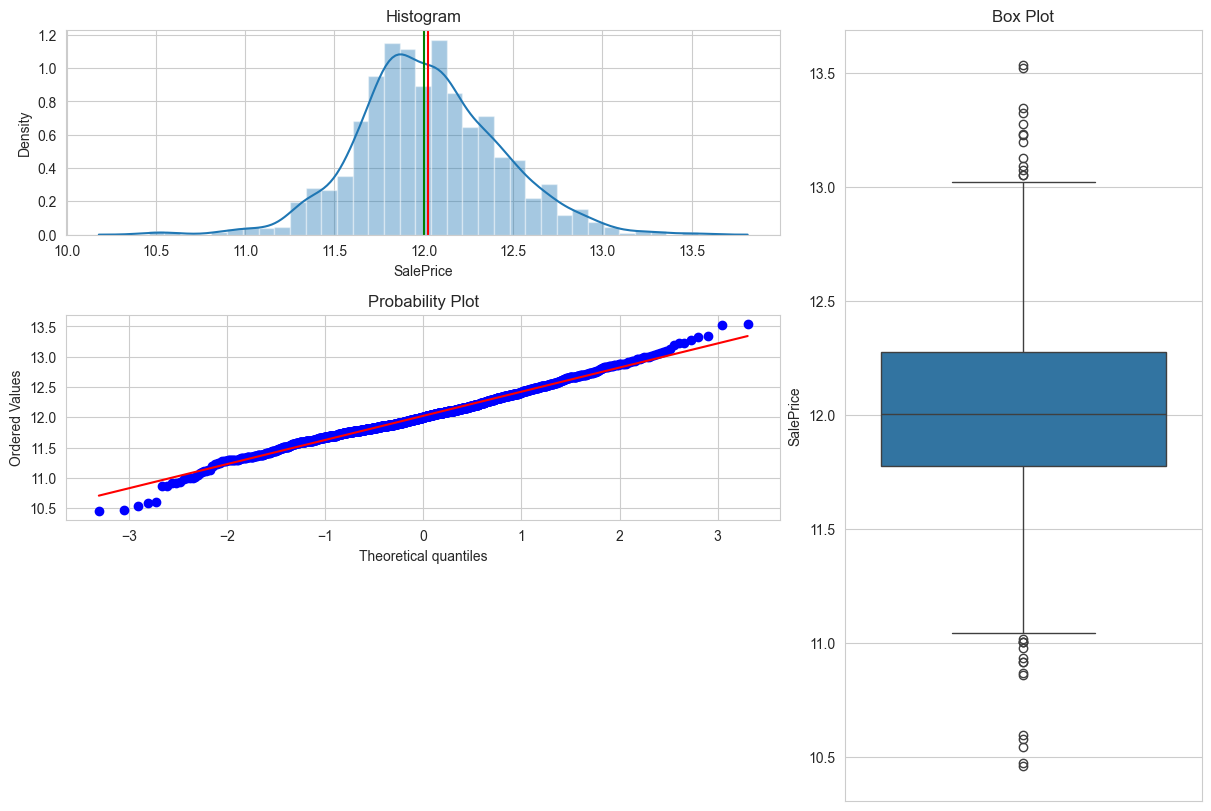

In [58]:
train["SalePrice"] = np.log1p(train["SalePrice"])
df = train
three_chart_plot(df, 'SalePrice')

<Figure size 1500x1000 with 0 Axes>

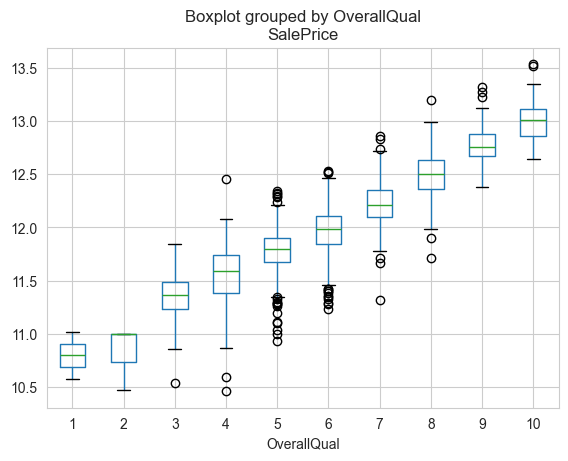

In [60]:
plt.figure(figsize = ((15, 10)))
df.boxplot(by = 'OverallQual', column = 'SalePrice')
plt.show()

In [63]:
def horizontal_plot(data, column_name, color, plot_title):
    
    fig, ax = plt.subplots(figsize = (9, 6))
    
    title_cnt = data[column_name].value_counts().sort_values(ascending = False).reset_index()

    mn = ax.barh(title_cnt.iloc[:, 0], title_cnt.iloc[:, 1], edgecolor = 'black', color =
                sns.color_palette(color, len(title_cnt)))

    for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)

    # Remove x,y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=10)

    # Add x,y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=1, alpha=0.2)

    # Show top values 
    ax.invert_yaxis()

    ax.set_title(plot_title,weight='bold',loc='center', pad=10, fontsize=16)
    
    ax.set_xlabel('Count', weight='bold')

    for i in ax.patches:
        ax.text(i.get_width() + 1.0, i.get_y() + 0.5, str(round((i.get_width()), 2)),
                fontsize=10, fontweight='bold', color='grey')

    plt.yticks(weight='bold')
    plt.xticks(weight='bold')

    plt.show()

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

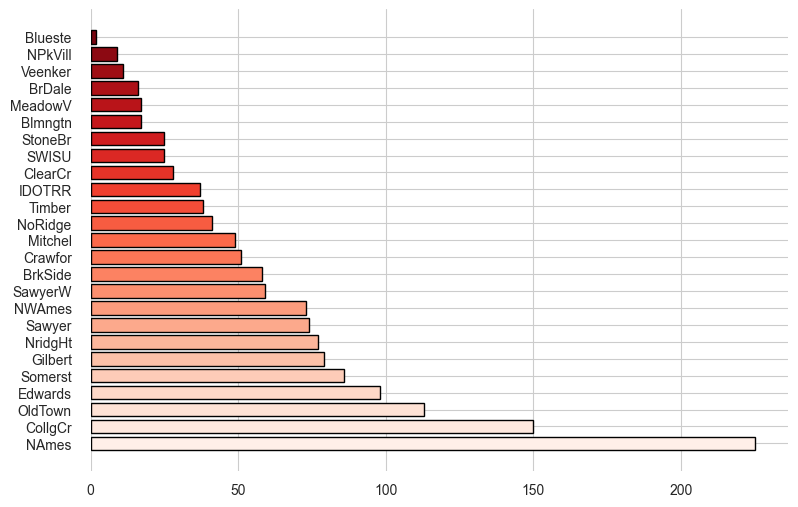

In [64]:
horizontal_plot(df, 'Neighborhood', 'Reds', 'Most frequent neighborhoods')

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

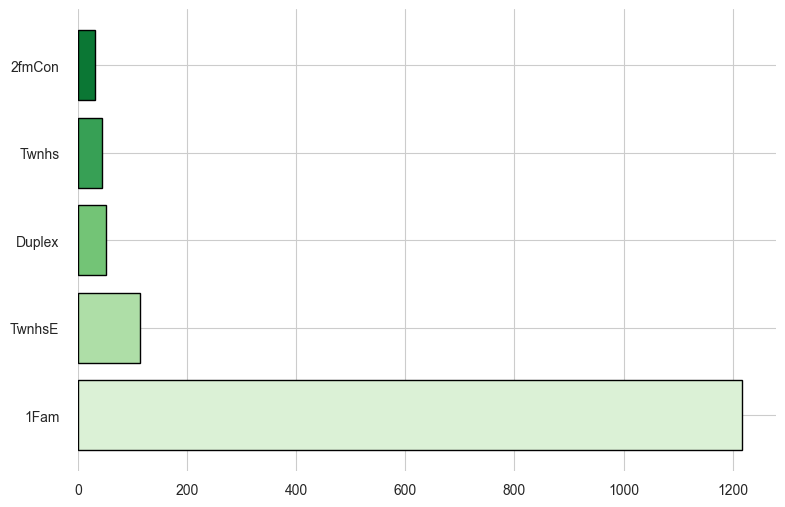

In [65]:
horizontal_plot(df, 'BldgType', 'Greens', 'Building type: Type of dwelling')

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

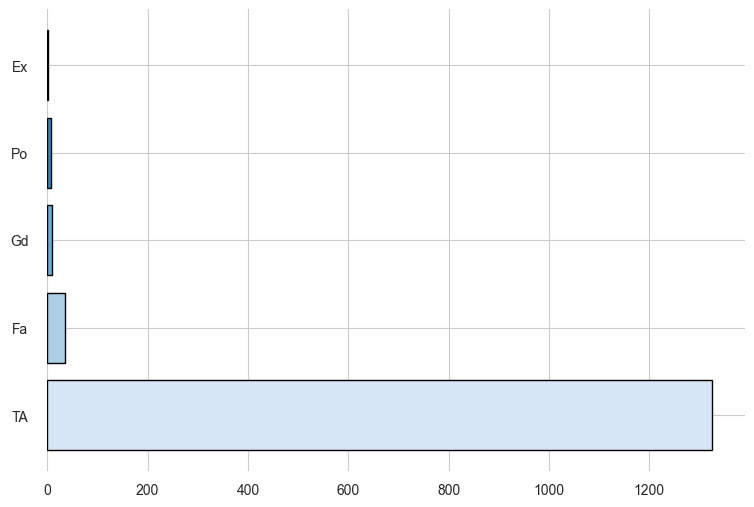

In [66]:
horizontal_plot(df, 'GarageCond', 'Blues', 'Garage Condition')


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

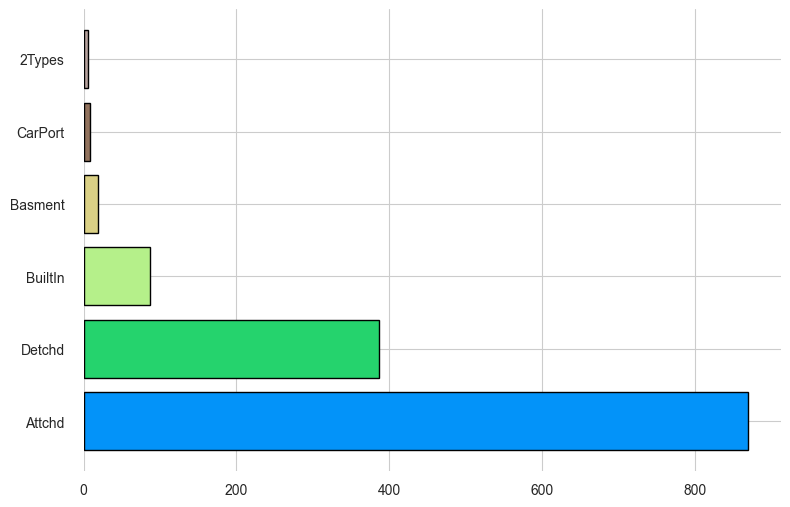

In [67]:
horizontal_plot(df, 'GarageType', 'terrain', 'Garage Type')


In [68]:
y = df['SalePrice'].reset_index(drop = True)
train_features = df.drop('SalePrice', axis = 1)
test_features = test.copy()

features = pd.concat((train_features, test_features)).reset_index(drop = True)

In [69]:
features.shape


(2917, 79)

In [70]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['MoSold'] = features['MoSold'].astype(str)
features['YrSold'] = features['YrSold'].astype(str)

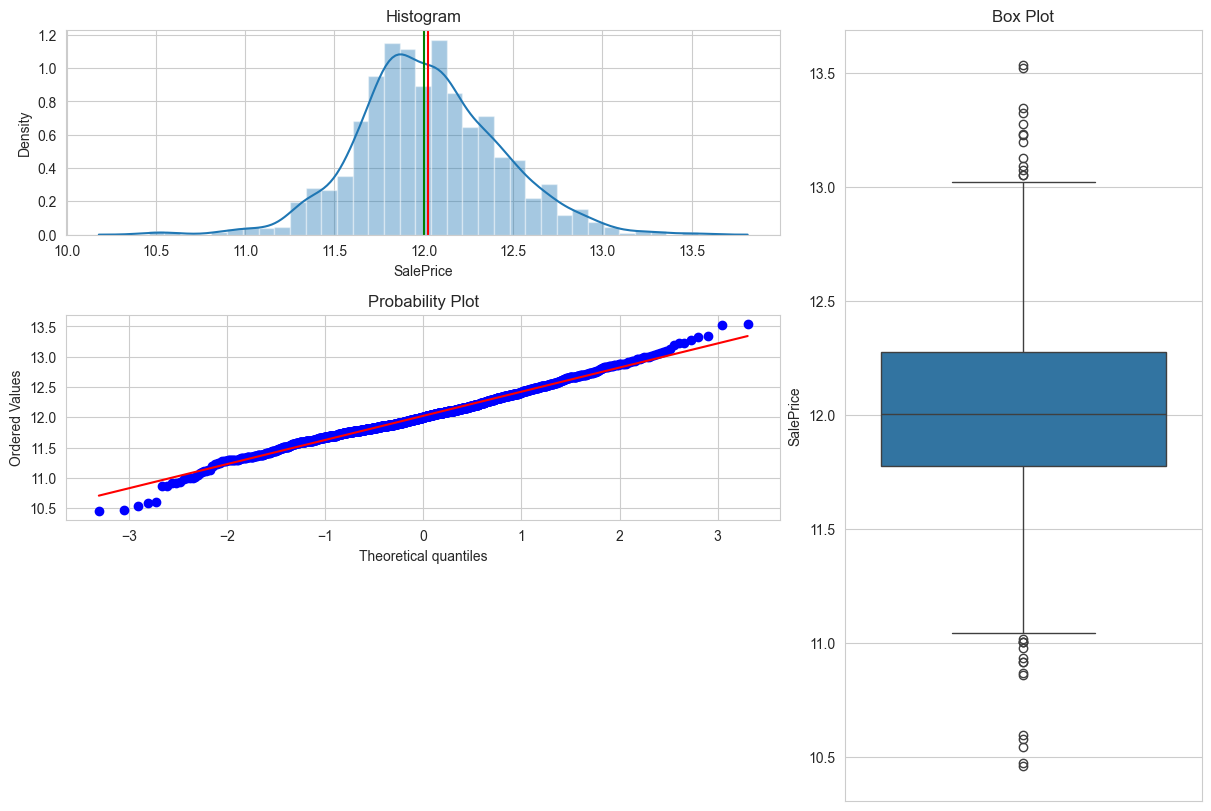

In [71]:
three_chart_plot(df, 'SalePrice')

In [72]:
null_table(features).sort_values(by = 'Approximate Percentage of Null Values').tail(10)

,Columns,Count of Null Values,Approximate Percentage of Null Values
63,GarageCond,159,5.450806
59,GarageFinish,159,5.450806
62,GarageQual,159,5.450806
2,LotFrontage,486,16.660953
56,FireplaceQu,1420,48.680151
24,MasVnrType,1766,60.541652
72,Fence,2346,80.425094
5,Alley,2719,93.212204
73,MiscFeature,2812,96.400411
71,PoolQC,2908,99.691464


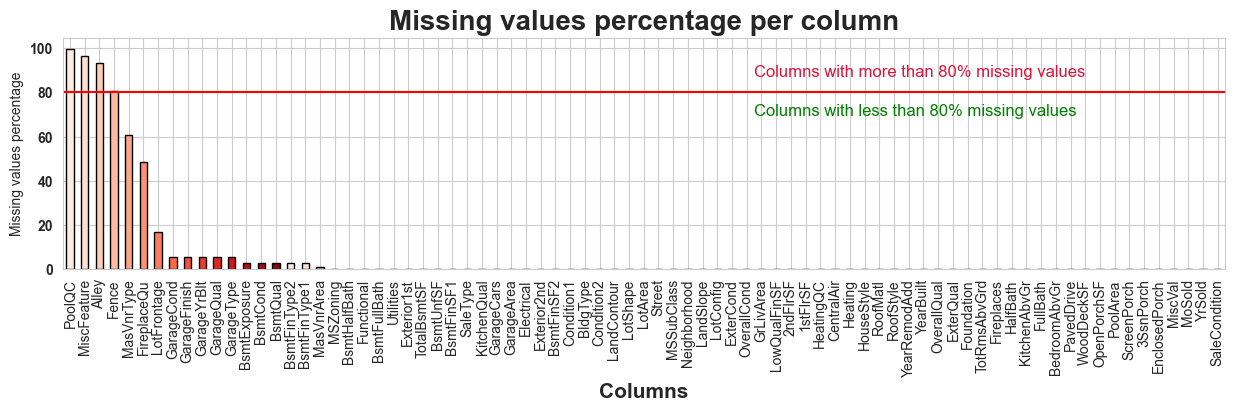

In [73]:
msv_1(features, 80, color = sns.color_palette('Reds',15))

In [74]:
features = features.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1)
features.shape

(2917, 75)

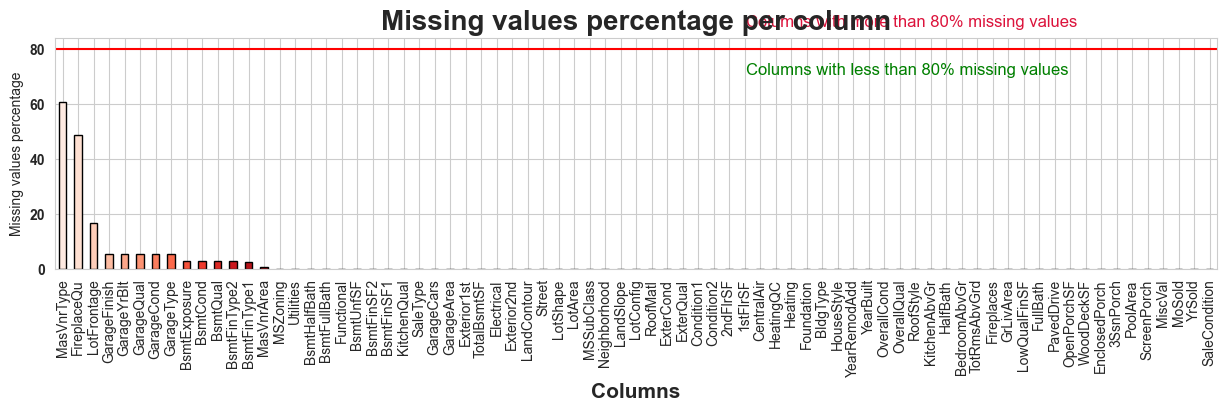

In [75]:
msv_1(features, 80, color = sns.color_palette('Reds',15))

In [77]:
description = open(r"C:\Users\Admin\OneDrive\Desktop\house_price_prediction\data\data_description.txt", "r")
print(description.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [78]:
def filling_null(features):
    
    features['Functional'] = features['Functional'].fillna('Typ')
    
    features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
    
    features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])

    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    cat_features = features.select_dtypes(include = 'object').columns
    num_features = features.select_dtypes(exclude = 'object').columns
    
    features[cat_features] = features[cat_features].fillna('None')
    features[num_features] = features[num_features].fillna(0)
        
    return features

In [79]:
features = filling_null(features)
features.shape

(2917, 75)

In [80]:
features.isnull().sum().sum()

np.int64(0)

In [81]:
def new_features(features):
    
    features['HasPool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    features['Has2ndFloor'] = features['2ndFlrSF'].apply(lambda x : 1 if x > 0 else 0)
    features['HasGarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    features['HasBsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    features['HasFireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                                   features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
    
    features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                                  features['EnclosedPorch'] + features['ScreenPorch'])

    # Add years since remodel
    features['YearsSinceRemodel'] = features['YrSold'].astype(int) - features['YearRemodAdd'].astype(int)

    return features

In [82]:
features = new_features(features)
features.shape

(2917, 83)

In [83]:
num_features = features.select_dtypes(exclude = 'object').columns

skewed_features = features[num_features].apply(lambda x : x.skew()).sort_values(ascending = False)
skew_features = pd.DataFrame({'Skew Value' : skewed_features})

skew_features.head(10)

,Skew Value
MiscVal,21.950962
PoolArea,17.697766
HasPool,15.502729
LotArea,13.116240
LowQualFinSF,12.090757
3SsnPorch,11.377932
KitchenAbvGr,4.302763
BsmtFinSF2,4.146636
EnclosedPorch,4.004404
ScreenPorch,3.947131


In [84]:
def fix_skew(features):
    
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numerical_columns = features.select_dtypes(exclude = 'object').columns

    # Check the skew of all numerical features
    skewed_features = features[numerical_columns].apply(lambda x: x.skew()).sort_values(ascending=False)
    
    high_skew = skewed_features[abs(skewed_features) > 0.5]
    skewed_features = high_skew.index

    # Perform the Box-Cox transformation
    for column in skewed_features:
        features[column] = boxcox1p(features[column], boxcox_normmax(features[column] + 1))
        
    return features

In [86]:
features = pd.get_dummies(features).reset_index(drop=True)
features.shape

(2917, 323)

In [87]:
X = features.iloc[:len(y), :]
test = features.iloc[len(y):, :]

In [88]:
X.shape, test.shape, y.shape


((1458, 323), (1459, 323), (1458,))

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [91]:
def evaluation(model, x_train_std, y_train, x_test, y_test, train = True):
    if train == True:
        pred = model.predict(x_train_std)
        
        print("Train Result:\n================================================")
        print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, pred))}")
        print("_______________________________________________")
        print(f"Mean Squared Error: {mean_squared_error(y_train, pred)}")
        print("_______________________________________________")
        print(f"Mean Absolute Error: \n{mean_absolute_error(y_train, pred)}")
        print("_______________________________________________")
        
    print()
    
    if train == False:
        pred = model.predict(x_test)
        
        print("Test Result:\n================================================")
        print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, pred))}")
        print("_______________________________________________")
        print(f"Mean Squared Error: {mean_squared_error(y_test, pred)}")
        print("_______________________________________________")
        print(f"Mean Absolute Error: \n{mean_absolute_error(y_test, pred)}")
        print("_______________________________________________")

In [92]:
from sklearn.linear_model import Lasso
ls = Lasso(alpha = 0.1)
ls.fit(X_train, y_train)

evaluation(ls, X_train, y_train, X_test, y_test, True)
evaluation(ls, X_train, y_train, X_test, y_test, False)

Train Result:
Root Mean Squared Error: 0.1559305603074774
_______________________________________________
Mean Squared Error: 0.02431433963780385
_______________________________________________
Mean Absolute Error: 
0.10902872256820452
_______________________________________________


Test Result:
Root Mean Squared Error: 0.14961670284619952
_______________________________________________
Mean Squared Error: 0.022385157770567966
_______________________________________________
Mean Absolute Error: 
0.1082165499568553
_______________________________________________


In [93]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 0.1)
ridge.fit(X_train, y_train)

evaluation(ridge, X_train, y_train, X_test, y_test, True)
evaluation(ridge, X_train, y_train, X_test, y_test, False)

Train Result:
Root Mean Squared Error: 0.08767556067251914
_______________________________________________
Mean Squared Error: 0.007687003939240584
_______________________________________________
Mean Absolute Error: 
0.0614099200310258
_______________________________________________


Test Result:
Root Mean Squared Error: 0.1213010325270071
_______________________________________________
Mean Squared Error: 0.014713940492118032
_______________________________________________
Mean Absolute Error: 
0.08730921231199462
_______________________________________________


In [95]:
import xgboost as xgb
xgb_regress = xgb.XGBRegressor(n_estimators = 1000, learning_rate = 0.1)
xgb_regress.fit(X_train, y_train)

evaluation(xgb_regress, X_train, y_train, X_test, y_test, True)
evaluation(xgb_regress, X_train, y_train, X_test, y_test, False)

Train Result:
Root Mean Squared Error: 0.001456885203466026
_______________________________________________
Mean Squared Error: 2.1225144960782435e-06
_______________________________________________
Mean Absolute Error: 
0.0009707197915499456
_______________________________________________


Test Result:
Root Mean Squared Error: 0.1227362065937865
_______________________________________________
Mean Squared Error: 0.015064176409032641
_______________________________________________
Mean Absolute Error: 
0.0893353012331724
_______________________________________________


In [96]:
test_pred = ridge.predict(test)
submission = pd.DataFrame(test_id, columns = ['Id'])
test_pred = np.expm1(test_pred)
submission['SalePrice'] = test_pred 
submission.head()

,Id,SalePrice
0,1461,116650.142432
1,1462,158486.092258
2,1463,185428.395518
3,1464,202868.832880
4,1465,207906.058312


In [97]:
submission.to_csv("result_ridge.csv", index = False, header = True)